# Decision tree and random forest from scratch

## Decision tree

* A decision tree is hierarchical series of questions that will lead to different outcomes depending on the result of the questions

<img src="Fig/tree2.svg" width=200 >

* In machine learning, the "optimal" questions are derived from a traning data set by recursively splitting the dataset into relative "homogeneous" subsets


In [1]:
using PyPlot

* We use the example dataset from to classify Bank notes into genuine and forged bank notes available at http://archive.ics.uci.edu/ml/datasets/banknote+authentication
* First download the datafile (if necessary) 

In [2]:
fname = "data_banknote_authentication.txt"

if !isfile(fname)
    download("http://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt",fname)
end

Let's have a quite look at the first 3 rows

In [3]:
readlines(fname)[1:3]

3-element Array{String,1}:
 "3.6216,8.6661,-2.8073,-0.44699,0"
 "4.5459,8.1674,-2.4586,-1.4621,0" 
 "3.866,-2.6383,1.9242,0.10645,0"  

There is no header line and columns are separated by a comma

In [4]:
data = readdlm(fname,',');

The meaning of the columns:

1. variance of Wavelet Transformed image (continuous)
2. skewness of Wavelet Transformed image (continuous)
3. curtosis of Wavelet Transformed image (continuous)
4. entropy of image (continuous)
5. class (integer)


Apparently, some of the columns have been normalized.


$$\newcommand{\vec}{\mathbf}$$
* For the $i$th sample, $\vec x_i$ (`x[i,:]`) are the features and $y_i$ (`y[i]`) are the labels
* We split data into training and evaluation dataset
* `frac` denotes the fraction of the evaluation data set

In [5]:
srand(12345)

frac = 0.1
selecteval = rand(size(data,1)) .< frac
x = data[.!selecteval,1:4]
y = data[.!selecteval,5]
@show length(y)
@show sum(y .== 0)
@show sum(y .== 1)

xeval = data[selecteval,1:4]
yeval = data[selecteval,5]
@show length(yeval)

length(y) = 1240
sum(y .== 0) = 685
sum(y .== 1) = 555
length(yeval) = 132


132

Let's have a look at the dataset

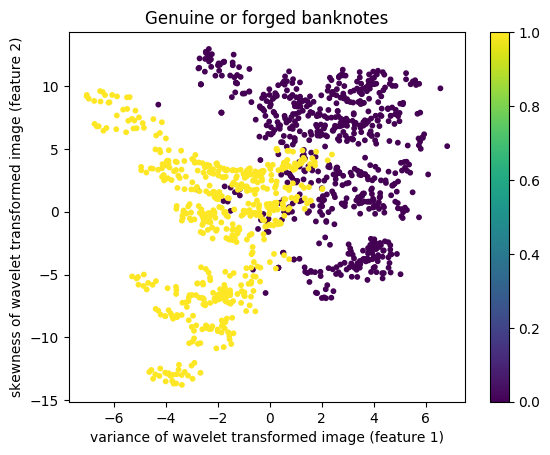

In [6]:
scatter(x[:,1],x[:,2],10,y)
xlabel("variance of wavelet transformed image (feature 1)")
ylabel("skewness of wavelet transformed image (feature 2)")
title("Genuine or forged banknotes")
colorbar();

As a test split the data according to feature 1 accoring the threshold equal to first sample

In [7]:
ifeature = 1
threshold  = x[1,ifeature]

3.6216

`splitflag` is true for the elements belong to subset 1 and false for elements belonging to subset 2

In [8]:
splitflag = x[:,ifeature] .< threshold;

In [9]:
sum(splitflag), sum(.!splitflag)

(1030, 210)

* A perfect question, whould split our dataset into two subsets where all labels in subset 1 would be 0 and all labels in subset 2 would 1. This would result in a perfectly homogenous or pure subset.
* In CART (Classification and Regression Trees), we would use the Gini impurity index to quantify the degree of homegenity in classification problems

## Gini impurity index

* We mesure the heterogenity within the two subsets (where splitflag is true or false) using the Gini index for each  of these subsets

* Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels
* So this mean:
   * choose a random element form the set
   * choose a random label from the set
   * the Gini index is the probability that we choose the __incorrect__ label for the element 

* What is the probablity to pick a correct label = probaility to pick an element with the label 1 *and* a label 1 *or* to pick an element with the label 2 *and* a label 2 ...

$$\begin{eqnarray}
P(\mbox{pick a correct label}) &=&  
P(\mbox{pick an element with the label 1 and pick a label 1}) \\
&& + P(\mbox{pick an element with the label 2 and pick a label 2}) \\
&& + P(\mbox{pick an element with the label 3 and pick a label 3}) \\
&& +... \\
&=&
P(\mbox{pick an element with the label 1}) \cdot {P(\mbox{pick a label 1})} \\
&& + P(\mbox{pick an element with the label 2}) \cdot {P(\mbox{pick a label 2})} \\
&& + ... \\ 
&=& \sum_i p_i^2
\end{eqnarray}
$$

where $p_i$ is the probability to pick an element with the label $i$ which is infact equal to the probability to pick a label $i$.

The Gini index is the probability to pick an *incorrect* label, therefore $1 - P(\mbox{pick a correct label})$:

$$
I_g(p_1, p_2, \dots) = 1 - \sum_i p_i^2
$$

The probability to pick an element with the label $i$, the probability to pick a label $i$ is just the fraction of all elements with the label i.

$$
p_i = \frac{\mbox{Number all elements with label $i$}}{\mbox{Number all elements}}
$$


In [10]:
y_subset = y[splitflag];
classes = [0.,1.]
probability = zeros(length(classes))
for i = 1:length(classes)
    probability[i] = sum(y_subset .== classes[i])/length(y_subset)
end
@show probability
gini = 1 - sum(probability.^2)

probability = [0.461165, 0.538835]


0.49698369309077195

In [11]:
function giniimpurity(y_subset,classes)
    gini_index = 1.
    probability = zeros(length(classes))

    for i = 1:length(classes)
       probability[i] = sum(y_subset .== classes[i])/length(y_subset)
    end
    gini = 1 - sum(probability.^2) 
    return gini
end

giniimpurity (generic function with 1 method)

For a completetly homogenous dataset the impurity is zero:

In [12]:
giniimpurity([1,1,1,1,1,1],classes)

0.0

If there are as many zeros than ones, the probability to pick a random incorrect label is 0.5:

In [13]:
giniimpurity([1,1,1,0,0,0],classes)

0.5

We chose a threshold value (more or less) at random, so it is no suprising that it has a very bad Gini impurity index

In [14]:
giniimpurity(y[splitflag],classes)

0.49698369309077195

The average Gini impurity is the mean Gini impurity of each class weighted by the total fraction of each class  

In [15]:
N = length(y)
N1 = sum(splitflag)
N2 = length(y)-N1
giniimpurity(y[splitflag],classes)*N1/N  + giniimpurity(y[.!splitflag],classes)*N2/N

0.4128170999060444

Average Gini index is minimized

In [16]:
function fitness(x,y,classes,ifeature,threshold)
    splitflag = x[:,ifeature] .< threshold;
    
    N = length(y)
    N1 = sum(splitflag)
    N2 = length(y)-N1
    return giniimpurity(y[splitflag],classes)*N1/N + giniimpurity(y[.!splitflag],classes)*N2/N  
end

fitness (generic function with 1 method)

In [17]:
fitness(x,y,classes,ifeature,threshold)

0.4128170999060444

In [18]:
thresholds = sort(x[:,ifeature])

fitness1 = [fitness(x,y,classes,ifeature,threshold) for threshold in thresholds];

Average Gini impurity index for different values of the threshold

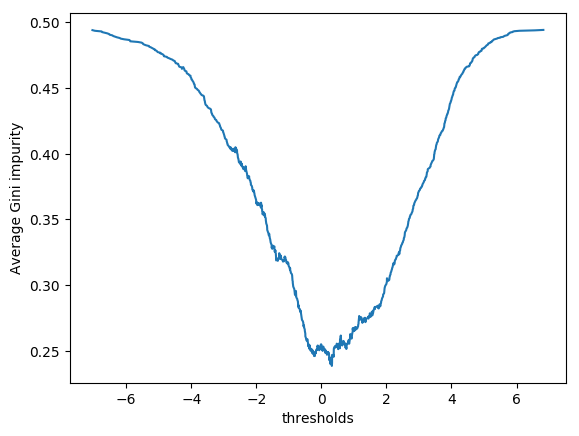

In [19]:
plot(thresholds,fitness1)
xlabel("thresholds")
ylabel("Average Gini impurity");


As there are only two choises and since the datasets is relatively balanced (there are as many fakes as non-fakes), it is clear that the average impurity tends to 0.5 for really bad questions

In [20]:
function bestthreshold(x,y,classes,ifeature)
    lowestavgGiniIndex = Inf
    threshold = 0.
    for i = 1:length(y)
        avgGiniIndex = fitness(x,y,classes,ifeature,x[i,ifeature])
        if avgGiniIndex < lowestavgGiniIndex
            # found a better threshold
            threshold = x[i,ifeature]
            lowestavgGiniIndex = avgGiniIndex
        end
        
    end
    return threshold,lowestavgGiniIndex
end

bestthreshold (generic function with 1 method)

In [21]:
threshold,lowestavgGiniIndex = bestthreshold(x,y,classes,ifeature)

(0.3223, 0.23838434398515596)

The optimal threshold value for feature 1

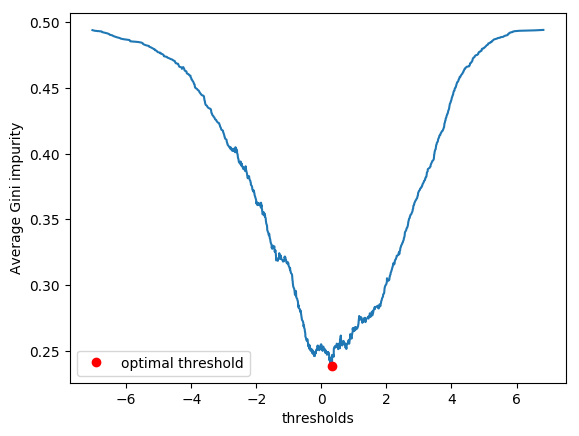

In [22]:
plot(thresholds,fitness1)
plot([threshold],[lowestavgGiniIndex],"ro",label="optimal threshold")
xlabel("thresholds")
ylabel("Average Gini impurity")
legend();

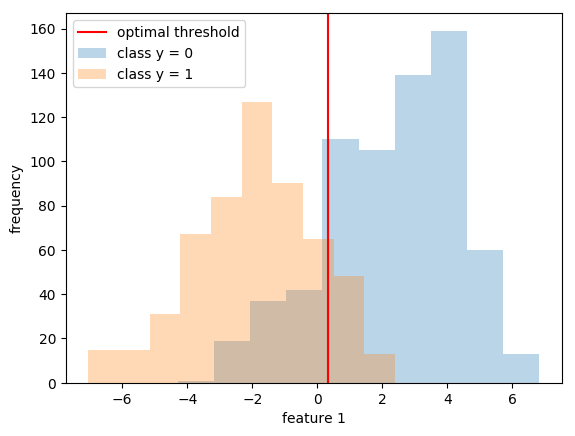

In [23]:
ifeature = 1
threshold,lowestavgGiniIndex = bestthreshold(x,y,classes,ifeature)
hist = PyPlot.plt[:hist];
hist(x[y .== 0,ifeature],histtype = "stepfilled",alpha = 0.3, label = "class y = 0")
hist(x[y .== 1,ifeature],histtype = "stepfilled",alpha = 0.3, label = "class y = 1")
axvline(threshold,color="r",label = "optimal threshold")
xlabel("feature $(ifeature)")
ylabel("frequency")
legend(loc = "upper left");

Among all features, determine which ones lead to the lowest average Gini impurity

In [24]:
[bestthreshold(x,y,classes,ifeature) for ifeature = 1:size(x,2)]

4-element Array{Tuple{Float64,Float64},1}:
 (0.3223, 0.238384)
 (5.1815, 0.374915)
 (8.7086, 0.446166)
 (1.6168, 0.489778)

Indeed the best split was obtained for feature 1

In [25]:
function bestfeature(x,y,classes)
    ifeature = 0
    lowestavgGiniIndex = Inf
    threshold = 0.
    
    for j = 1:size(x,2)
        thresholdj,avgGiniIndex = bestthreshold(x,y,classes,j)
        if avgGiniIndex < lowestavgGiniIndex
            # found a better feature
            threshold = thresholdj
            lowestavgGiniIndex = avgGiniIndex
            ifeature = j
        end
    end
    return ifeature,threshold,lowestavgGiniIndex
end

ifeature,threshold,lowestavgGiniIndex = bestfeature(x,y,classes)

(1, 0.3223, 0.23838434398515596)

In [26]:
# from https://github.com/JuliaStats/StatsBase.jl
# StatsBase.jl is licensed under the MIT License

function mode(a::AbstractArray{T}) where T
    isempty(a) && error("mode: input array cannot be empty.")
    cnts = Dict{T,Int}()
    # first element
    mc = 1
    mv = a[1]
    cnts[mv] = 1
    # find the mode along with table construction
    for i = 2 : length(a)
        @inbounds x = a[i]
        if haskey(cnts, x)
            c = (cnts[x] += 1)
            if c > mc
                mc = c
                mv = x
            end
        else
            cnts[x] = 1
            # in this case: c = 1, and thus c > mc won't happen
        end
    end
    return mv
end

mode([1,2,3,2])

2

In [27]:
type Decision
    value :: Float64
end

type Question
    ifeature :: Int
    threshold :: Float64
    next :: Vector{Union{Decision,Question}}
end

In [28]:
function split(x,y,classes,minsize,maxdepth,depth = 0)   
    # return early if the tree receases maximim depth or the 
    # minimum size
    if (depth == maxdepth) || (length(y) <= minsize)
        return Decision(mode(y))
    end
    
    # return early if all elements are the same
    if length(Set(y)) == 1
        return Decision(y[1])
    end
    
    
    ifeature,threshold,lowestavgGiniIndex = bestfeature(x,y,classes)
    #@show ifeature
    splitflag = x[:,ifeature] .< threshold;
    
    next = [
        split(x[splitflag,:],y[splitflag],classes,minsize,maxdepth,depth+1),
        split(x[.!splitflag,:],y[.!splitflag],classes,minsize,maxdepth,depth+1)        
    ]
    
    return Question(ifeature,threshold,next)
end

split (generic function with 2 methods)

Some functions to display a decision tree

In [29]:
function Base.show(io::IO,d::Decision) 
    indent = get(io, :indent, 0)
    print_with_color(:green,io," " ^ indent,"Decision: $(d.value)\n")
end
function Base.show(io::IO,q::Question)
    indent = get(io, :indent, 0)
    blank = " " ^ indent
    println(io,blank,"if feature $(q.ifeature) < $(q.threshold)")
    
    io2 = IOContext(io,indent=indent+2)
    show(io2,q.next[1])
    println(io,blank,"else")
    show(io2,q.next[2])
    println(io,blank,"end")
end

Build a decision tree with a maximum depth of 30

In [38]:
maxdepth = 2
minsize = 1
tree = split(x,y,classes,minsize,maxdepth)

if feature 1 < 0.3223
  if feature 2 < 7.6274
    Decision: 1.0
  else
    Decision: 0.0
  end
else
  if feature 3 < -4.3839
    Decision: 1.0
  else
    Decision: 0.0
  end
end


In [31]:
predict(d::Decision,xi) = d.value

function predict(q::Question,xi)
   if xi[q.ifeature] < q.threshold
        return predict(q.next[1],xi)
    else
        return predict(q.next[2],xi)
    end
end



predict (generic function with 2 methods)

Validate the tree with the independent validation data set

In [32]:
function ncorrect(tree,xeval,yeval)
   N = 0
   for i in 1:length(yeval)
     if predict(tree,xeval[i,:]) == yeval[i]
        N = N+1
     end
   end
  return N
end

percentcorrect = 100.*ncorrect(tree,xeval,yeval)/length(yeval)
println("Percentage of correct predictions (for evaluation dataset): $(percentcorrect) %")



Percentage of correct predictions (for evaluation dataset): 87.87878787878788 %


In [33]:
maxdepths = 1:10
minsize = 1
percentcorrect = zeros(length(maxdepths))
for i = 1:length(maxdepths)
    tree = split(x,y,classes,minsize,maxdepths[i])
    percentcorrect[i] = 100.*ncorrect(tree,xeval,yeval)/length(yeval)
end

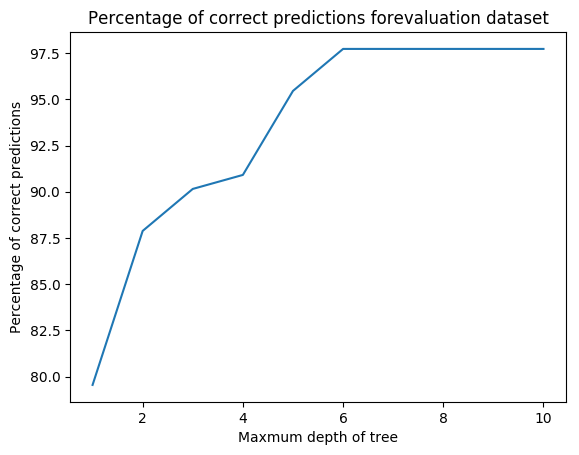

In [34]:
plot(maxdepths,percentcorrect)
xlabel("Maxmum depth of tree")
ylabel("Percentage of correct predictions")
title("Percentage of correct predictions forevaluation dataset");

In [35]:
maxdepths = 1:10
minsizes = 1:20:81
percentcorrect = zeros(length(maxdepths),length(minsizes))
for i = 1:length(maxdepths)
for j = 1:length(minsizes)
    tree = split(x,y,classes,minsizes[j],maxdepths[i])
    percentcorrect[i,j] = 100.*ncorrect(tree,xeval,yeval)/length(yeval)
end
end

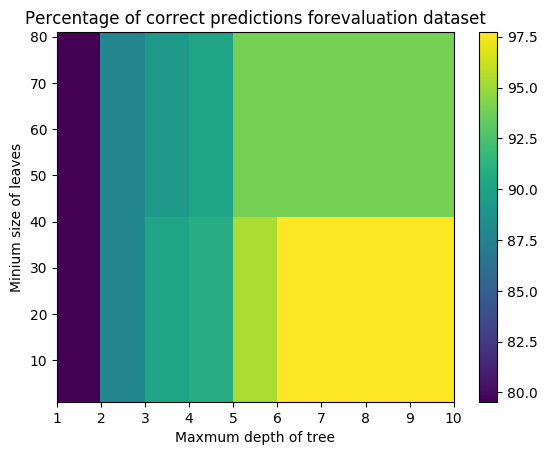

In [36]:
pcolor(maxdepths,minsizes,percentcorrect')
colorbar()
xlabel("Maxmum depth of tree")
ylabel("Minium size of leaves")
title("Percentage of correct predictions forevaluation dataset");

* Performance does not degrate when maximum tree depth is increased for this case

# Final notes

* Regression trees -> replace Gini impurity by variance and the mode by the mean
* Tree prunning should be used
* Random forest:
   * Split dataset into several so called _bags_
   * Derive a decision tree for each bag
   * For prediction, apply all trees to the feature vector and the final answer is the mode (for classification) or mean (for regression) for the answers of all trees

## References


* Dua, Dheeru and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

*  How To Implement The Decision Tree Algorithm From Scratch In Python
By Jason Brownlee on November 9, 2016 https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/
